In [2]:
%cd ..

/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys


In [4]:
import os 
import sys
import pickle
import numpy as np
# Add the project root to Python path
# sys.path.insert(0, '/blue/npadillacoreano/mcum/SynapticSync/src')
#from spike.spike_analysis.spike_collection import SpikeCollection
#from synapticsync.spike.spike_collection import SpikeCollection

In [4]:
def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl
    Returns:
        none
    """
    with open(file_name, "wb") as file:
        pickle.dump(thing_to_pickle, file)
def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, "rb") as file:
        return pickle.load(file)

# Make subject dict

In [5]:
behavior_dicts = {}

def make_recording_to_subj_dict(data_path):
    recording_to_subject = {}
    for root, dirs, files in os.walk(data_path):
        for file in dirs:
            if file.endswith('merged.rec'):
                if file.startswith('2023'):
                    subject = str(file.split("_")[-4].replace('-','.'))
                    recording_to_subject[file] = subject
                    behavior_dicts[file] = {}
                if file.startswith('2024'):
                    subject = str(file.split("_")[-3].replace('-','.'))
                    recording_to_subject[file] = subject
                    behavior_dicts[file] = {}   
                if (file == '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged.rec')| (file == '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged.rec'):
                    subject = str(file.split("_")[-5].replace('-','.'))
                    recording_to_subject[file] = subject
                    behavior_dicts[file] = {}
                if file =='20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged.rec':
                    recording_to_subject[file] = '1.1'
                if file == '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged.rec':
                    recording_to_subject[file] = '1.4'
                
    return recording_to_subject

subject_dict = make_recording_to_subj_dict(r"/blue/npadillacoreano/share/reward_comp_extention/Phy_rce2_rce3/phy_curation/megadataset")

# Make/clean event dict

In [6]:
event_dict = unpickle_this(r"/blue/npadillacoreano/share/reward_comp_extention/event_dict.pkl")
ms_event_dict = {}
# convert sampoling rate to miliseconds
original_keys = 'high_comp_lose', 'high_comp_win', 'low_comp_lose', 'low_comp_win', 'alone_rewarded'
# USE THIS 
for recording, inner_dict in event_dict.items():
    ms_event_dict[recording] = {}
    for name, event in inner_dict.items():
        event = np.array(event)
        if len(event.shape) > 1:
            event = event /20
            ms_event_dict[recording][name] = event
        else:
            ms_event_dict[recording][name] = np.empty((0,2))
    for events in original_keys:
        starts = ms_event_dict[recording][events]
        try:
            event_baseline = starts - 10000
        except IndexError:
            event_baseline =  np.empty((0, 2))
        ms_event_dict[recording][f'{events}_baseline'] = event_baseline
        
        
################################################################################        
for recording in ms_event_dict.keys():
    baselines = [ms_event_dict[recording]['high_comp_lose_baseline'], 
                 ms_event_dict[recording]['high_comp_win_baseline'],
                 ms_event_dict[recording]['low_comp_lose_baseline'], 
                 ms_event_dict[recording]['low_comp_win_baseline']]
    
    # Filter out empty arrays
    non_empty_baselines = [b for b in baselines if b.size > 0]
    
    if non_empty_baselines:  # Only stack if there are non-empty arrays
        all_baselines = np.vstack(non_empty_baselines)
        ms_event_dict[recording]['overall_pretone'] = all_baselines
        
for recording in ms_event_dict.keys(): 
    hc_lose = ms_event_dict[recording]['high_comp_lose']
    hc_win = ms_event_dict[recording]['high_comp_win']
    lc_win = ms_event_dict[recording]['low_comp_win']
    lc_lose = ms_event_dict[recording]['low_comp_lose']
    # Handle win events
    if len(hc_win.shape) > 1 and len(lc_win.shape) > 1:
        win = np.vstack([hc_win, lc_win])
        ms_event_dict[recording]['win'] = win
    elif hc_win.size > 1:
        ms_event_dict[recording]['win'] = hc_win
    elif lc_win.size > 1:
        ms_event_dict[recording]['win'] = lc_win
    else:
        ms_event_dict[recording]['win'] = np.array([]).reshape(0, hc_win.shape[1]) if hc_win.ndim > 1 else np.array([])
    
    # Handle lose events
    if len(hc_lose.shape) > 1 and len(lc_lose.shape) > 1:
        ms_event_dict[recording]['lose'] = np.vstack([hc_lose, lc_lose])
    elif hc_lose.size > 1:
        ms_event_dict[recording]['lose'] = hc_lose
    elif lc_lose.size > 1:
        ms_event_dict[recording]['lose'] = lc_lose
    else:
        ms_event_dict[recording]['lose'] = np.array([]).reshape(0, hc_lose.shape[1]) if hc_lose.ndim > 1 else np.array([])
    
    # Handle high_comp events
    if len(hc_lose.shape) > 1 and len(hc_win.shape) > 1:
        ms_event_dict[recording]['high_comp'] = np.vstack([hc_lose, hc_win])
    elif hc_lose.size > 1:
        ms_event_dict[recording]['high_comp'] = hc_lose
    elif hc_win.size > 1:
        ms_event_dict[recording]['high_comp'] = hc_win
    else:
        ms_event_dict[recording]['high_comp'] = np.array([]).reshape(0, hc_lose.shape[1]) if hc_lose.ndim > 1 else np.array([])
    
    # Handle low_comp events
    if len(lc_lose.shape) > 1 and len(lc_win.shape) > 1:
        ms_event_dict[recording]['low_comp'] = np.vstack([lc_lose, lc_win])
    elif lc_lose.size > 1:
        ms_event_dict[recording]['low_comp'] = lc_lose
    elif lc_win.size > 1:
        ms_event_dict[recording]['low_comp'] = lc_win
    else:
        ms_event_dict[recording]['low_comp'] = np.array([]).reshape(0, lc_lose.shape[1]) if lc_lose.ndim > 1 else np.array([])



In [7]:
pickle_this(ms_event_dict, '/blue/npadillacoreano/share/reward_comp_extention/ms_event_dict_complete.pkl')

# Make spike object

In [8]:
sc_object = SpikeCollection(path=r"/blue/npadillacoreano/share/reward_comp_extention/Phy_rce2_rce3/phy_curation/megadataset",
                            event_dict=ms_event_dict, # event dict from /blue/npadillacoreano/share/reward_comp_extention/event_dict.pkl
                            subject_dict=subject_dict) # 
    

loading  20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged.rec
loading  20230614_114041_standard_comp_to_training_D3_subj_1-2_t2b2L_box2_merged.rec
loading  20240320_114629_long_comp_subj_5-3_t6b6_merged.rec
loading  20240317_172017_long_comp_subj_4-2_t6b6_merged.rec
loading  20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged.rec
loading  20230618_100636_standard_comp_to_omission_D2_subj_1-1_t1b2L_box2_merged.rec
loading  20240323_165815_alone_comp_subj_4-4_t6b6_merged.rec
20240323_165815_alone_comp_subj_4-4_t6b6_merged.rec has no good units
and will not be included in the collection
loading  20240318_170933_long_comp_subj_4-3_t6b6_merged.rec
loading  20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged.rec
loading  20230613_105657_standard_comp_to_training_D2_subj_1-4_t4b3L_box2_merged.rec
loading  20240322_120625_alone_comp_subj_3-4_t5b5_merged.rec
loading  20240321_114851_long_comp_subj_5-3_t5b5_merged.rec
loading  20240

In [9]:
#sc_object.save_collection(r"/blue/npadillacoreano/share/reward_comp_extention/Phy_rce2_rce3/spike_collection.json")


In [10]:
#sc_tester_object = SpikeCollection.load_collection(r"/blue/npadillacoreano/share/reward_comp_extention/Phy_rce2_rce3/spike_collection.json")

In [11]:
sc_object.recording_details()

Recording Details:

Recording: 20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged.rec
  Subject: 1.4
  Number of Good Units: 20
  Recording Length: 58.17 minutes
  Events per Event Type: {'low_comp_win': 2, 'high_comp_lose': 10, 'low_comp_lose': 8, 'alone_rewarded': 0, 'high_comp_win': 0, 'high_comp_lose_baseline': 10, 'high_comp_win_baseline': 0, 'low_comp_lose_baseline': 8, 'low_comp_win_baseline': 2, 'alone_rewarded_baseline': 0, 'overall_pretone': 20, 'win': 2, 'lose': 18, 'high_comp': 10, 'low_comp': 10}

Recording: 20230614_114041_standard_comp_to_training_D3_subj_1-2_t2b2L_box2_merged.rec
  Subject: 1.2
  Number of Good Units: 27
  Recording Length: 53.36 minutes
  Events per Event Type: {'high_comp_win': 5, 'low_comp_win': 1, 'low_comp_lose': 5, 'high_comp_lose': 9, 'alone_rewarded': 38, 'high_comp_lose_baseline': 9, 'high_comp_win_baseline': 5, 'low_comp_lose_baseline': 5, 'low_comp_win_baseline': 1, 'alone_rewarded_baseline': 38, 'overall_pretone': 20, 'w

All set to analyze
Excluding 20240320_114629_long_comp_subj_5-3_t6b6_merged.rec with 4 neurons
Excluding 20240322_120625_alone_comp_subj_3-4_t5b5_merged.rec with 5 neurons
Excluding 20240323_144517_alone_comp_subj_3-4_t6b6_merged.rec with 6 neurons
Excluding 20240323_122227_alone_comp_subj_5-2_t6b6_merged.rec with 5 neurons
Excluding 20240318_143819_long_comp_subj_3-3_t6b6_merged.rec, it has no win events
Excluding 20240320_171038_alone_comp_subj_4-3_t5b5_merged.rec, it has no lose events
Excluding 20240317_151922_long_comp_subj_3-1_t6b6_merged.rec with 5 neurons
Excluding 20240318_143819_long_comp_subj_3-4_t5b5_merged.rec with 6 neurons
Excluding 20240320_171038_alone_comp_subj_4-2_t6b6_merged.rec with 4 neurons


/blue/npadillacoreano/mcum/conda/envs/lfp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


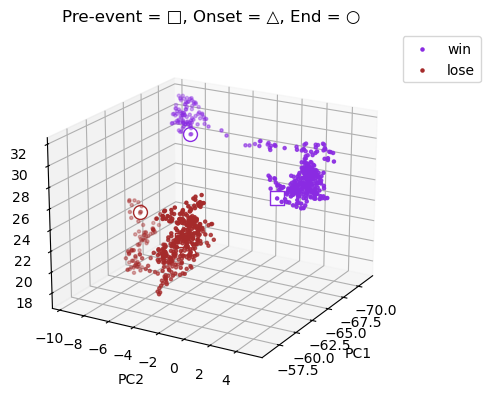

PCA Result with:
Events: win, lose
Timebins per event: 400.0
Total neurons: 460
Number of recordings: 30
Number of Pcs needed to explain 90% of variance 70
Excluding 20240320_114629_long_comp_subj_5-3_t6b6_merged.rec with 4 neurons
Excluding 20240322_120625_alone_comp_subj_3-4_t5b5_merged.rec with 5 neurons
Excluding 20240323_144517_alone_comp_subj_3-4_t6b6_merged.rec with 6 neurons
Excluding 20240323_122227_alone_comp_subj_5-2_t6b6_merged.rec with 5 neurons
Excluding 20240317_151922_long_comp_subj_3-1_t6b6_merged.rec with 5 neurons
Excluding 20240318_143819_long_comp_subj_3-4_t5b5_merged.rec with 6 neurons
Excluding 20240320_171038_alone_comp_subj_4-2_t6b6_merged.rec with 4 neurons


/blue/npadillacoreano/mcum/conda/envs/lfp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


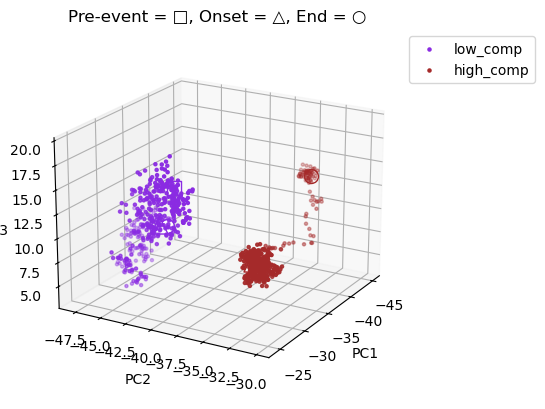

PCA Result with:
Events: low_comp, high_comp
Timebins per event: 400.0
Total neurons: 498
Number of recordings: 32
Number of Pcs needed to explain 90% of variance 84
Excluding 20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged.rec, it has no high_comp_win events
Excluding 20240320_114629_long_comp_subj_5-3_t6b6_merged.rec with 4 neurons
Excluding 20240317_172017_long_comp_subj_4-2_t6b6_merged.rec, it has no low_comp_win events
Excluding 20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged.rec, it has no low_comp_lose events
Excluding 20240318_170933_long_comp_subj_4-3_t6b6_merged.rec, it has no low_comp_lose events
Excluding 20230613_105657_standard_comp_to_training_D2_subj_1-4_t4b3L_box2_merged.rec, it has no high_comp_win events
Excluding 20240322_120625_alone_comp_subj_3-4_t5b5_merged.rec with 5 neurons
Excluding 20240321_114851_long_comp_subj_5-3_t5b5_merged.rec, it has no low_comp_lose events
Excluding 20240323_144517_alone_comp_subj_3-4_t6

/blue/npadillacoreano/mcum/conda/envs/lfp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


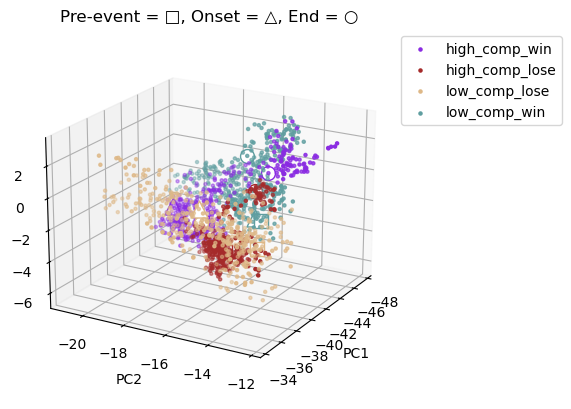

PCA Result with:
Events: high_comp_win, high_comp_lose, low_comp_lose, low_comp_win
Timebins per event: 400.0
Total neurons: 236
Number of recordings: 16
Number of Pcs needed to explain 90% of variance 73
Excluding 20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged.rec, it has no alone_rewarded events
Excluding 20240320_114629_long_comp_subj_5-3_t6b6_merged.rec with 4 neurons
Excluding 20240317_172017_long_comp_subj_4-2_t6b6_merged.rec, it has no alone_rewarded events
Excluding 20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged.rec, it has no alone_rewarded events
Excluding 20230618_100636_standard_comp_to_omission_D2_subj_1-1_t1b2L_box2_merged.rec, it has no alone_rewarded events
Excluding 20240318_170933_long_comp_subj_4-3_t6b6_merged.rec, it has no alone_rewarded events
Excluding 20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged.rec, it has no alone_rewarded events
Excluding 20240322_120625_alone_comp_subj_3-4_t5b5_mer

/blue/npadillacoreano/mcum/conda/envs/lfp_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


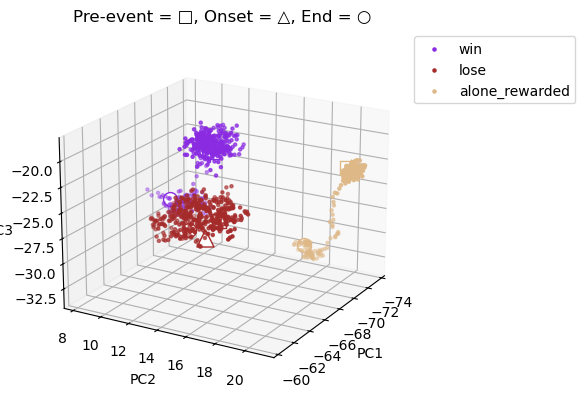

In [24]:
import spike.spike_analysis.pca_trajectories as pcat
# from importlib import reload
# reload(pcat)
sc_object.analyze(timebin = 50, ignore_freq = 0.5, smoothing_window = 250)

win_lose_pca = pcat.avg_trajectories_pca(sc_object, event_length = 10, pre_window = 10, events = ['win', 'lose'], min_neurons = 7, d = 3)
print(win_lose_pca)
hc_lc_pca = pcat.avg_trajectories_pca(sc_object, event_length = 10, pre_window = 10, events = ['low_comp', 'high_comp'], min_neurons = 7, d= 3)
print(hc_lc_pca)
all_pca = pcat.avg_trajectories_pca(sc_object, event_length = 10, pre_window = 10, events = ['high_comp_win', 'high_comp_lose', 'low_comp_lose','low_comp_win'], min_neurons = 7, d = 3)
print(all_pca)
alone_pca = pcat.avg_trajectories_pca(sc_object, event_length = 10, pre_window = 10, events = ['win', 'lose', 'alone_rewarded'], min_neurons = 7, d = 3)

In [20]:
print(alone_pca)

PCA Result with:
Events: win, lose, alone_rewarded
Timebins per event: 400.0
Total neurons: 236
Number of recordings: 16
Number of Pcs needed to explain 90% of variance 72


array([[  0.95181367,   0.61374911,   1.01443702, ...,  -5.61086293,
          4.53071209,  -1.57837974],
       [ -0.10352725,   1.08842846,  -0.65362668, ...,   2.76938412,
         -3.78891743,   2.88080853],
       [ -1.61603088,  -0.14997005,   0.33286613, ..., -23.19268374,
         -0.52563669,   0.68997628],
       ...,
       [  2.03980926,  -1.29112871,   0.43567356, ...,   1.10897879,
         -1.46496418, -11.69120634],
       [ -0.94073735,  -1.22695088,   1.54799082, ...,   0.88367967,
         -0.29146321,  -3.2348113 ],
       [  0.4498023 ,   0.57214995,   0.88272417, ...,  -0.22101969,
          1.18305268,   0.42487654]], shape=(236, 236))